In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
path = 'data/data.csv'
data = pd.read_csv(path)
normalized_pctg_change = data['normalized_percent_change'] # Save variable fot later use in model
data.drop(columns=['normalized_percent_change'], inplace=True)

In [ ]:
xgboost_df = data.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1] # Shape is rows x features (38)
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
random_state = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = xgb.DMatrix(X_train, y_train, label=y_train)
d_test = xgb.DMatrix(X_test, y_test, label=y_test)
best_params = {
    # Classification
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 0.1, # L1 regularization
    'lambda': 1, # L2 regularization
    'learning_rate': 0.1, 
    'max_depth': 7,
    'tree_method': 'hist', 
    'device': "cuda",
}
num_boost_round = 700
regression_params_short = {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 28/08/2024. Range (0,1)
regression_params_long = {'alpha': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 01/09/2024. Range (-1,1) Decreases coverage in Jackknife+ by 0.02
binary_params = {'alpha': 0, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 800, "eval_metric": 'auc', 'objective': 'binary:logistic', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda",} 

d_all = xgb.DMatrix(X)
model = xgb.train(best_params, d_train, num_boost_round=num_boost_round, evals=((d_test, "test"),),verbose_eval=False, early_stopping_rounds=10)
y_pred_proba_all = model.predict(d_all, iteration_range=(0, model.best_iteration + 1))
y_pred_all = (y_pred_proba_all > 0.5).astype(int)

In [ ]:
def cv_plus_conformal(X, y_binary, y_continuous, n_folds=10, alpha=0.9):
    """
    Cross-Validation+ conformal prediction implementation
    """
    # Convert to numpy arrays if they're pandas objects
    X_array = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
    y_binary_array = np.array(y_binary)
    y_continuous_array = np.array(y_continuous)
    
    n = len(X_array)
    fold_size = n // n_folds
    predictions = np.zeros(n)
    residuals = np.zeros(n)
    
    # Generate random fold assignments
    fold_indices = np.random.permutation(n)
    fold_assignments = np.array([i // fold_size for i in range(n)])
    
    # For each fold
    for fold in range(n_folds):
        train_mask = fold_assignments != fold
        val_mask = fold_assignments == fold
        
        classifier = xgb.XGBClassifier(**binary_params)
        classifier.fit(X_array[train_mask], y_binary_array[train_mask])
        
        mask_nonzero = y_binary_array[train_mask] == 1
        regressor = xgb.XGBRegressor(**regression_params_short)
        regressor.fit(X_array[train_mask][mask_nonzero], 
                     y_continuous_array[train_mask][mask_nonzero])
        
        val_probs = classifier.predict_proba(X_array[val_mask])[:, 1]
        val_pred = regressor.predict(X_array[val_mask])
        
        predictions[val_mask] = val_pred
        residuals[val_mask] = np.abs(y_continuous_array[val_mask] - val_pred)
    
    quantile = np.quantile(residuals, alpha)
    return predictions, quantile

In [ ]:
def jackknife_plus_ab_conformal(X, y_binary, y_continuous, n_resamplings=50, alpha=0.9):
    """
    Jackknife+AB conformal prediction implementation
    """
    # Convert to numpy arrays if they're pandas objects
    X_array = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
    y_binary_array = np.array(y_binary)
    y_continuous_array = np.array(y_continuous)
    
    n = len(X_array)
    predictions = np.zeros((n, n_resamplings))
    residuals = np.zeros((n, n_resamplings))
    
    for b in range(n_resamplings):
        bootstrap_indices = np.random.choice(n, size=n, replace=True)
        oob_mask = ~np.isin(np.arange(n), bootstrap_indices)
        
        classifier = xgb.XGBClassifier(**binary_params)
        classifier.fit(X_array[bootstrap_indices], y_binary_array[bootstrap_indices])
        
        mask_nonzero = y_binary_array[bootstrap_indices] == 1
        regressor = xgb.XGBRegressor(**regression_params_short)
        regressor.fit(X_array[bootstrap_indices][mask_nonzero], 
                     y_continuous_array[bootstrap_indices][mask_nonzero])
        
        if any(oob_mask):  # Only predict if there are out-of-bag samples
            oob_probs = classifier.predict_proba(X_array[oob_mask])[:, 1]
            oob_pred = regressor.predict(X_array[oob_mask])
            predictions[oob_mask, b] = oob_pred
            residuals[oob_mask, b] = np.abs(y_continuous_array[oob_mask] - oob_pred)
    
    mean_predictions = np.nanmean(predictions, axis=1)
    max_residuals = np.nanmax(residuals, axis=1)
    quantile = np.quantile(max_residuals[~np.isnan(max_residuals)], alpha)
    
    return mean_predictions, quantile

In [ ]:
def conformal_prediction_with_method(X, y_binary, y_continuous, method='cv_plus', alpha=0.9):
    if method == 'cv_plus':
        predictions, quantile = cv_plus_conformal(X, y_binary, y_continuous, alpha=alpha)
    elif method == 'jackknife_plus_ab':
        predictions, quantile = jackknife_plus_ab_conformal(X, y_binary, y_continuous, alpha=alpha)
    else:
        raise ValueError("Method must be 'cv_plus' or 'jackknife_plus_ab'")
    
    # Create prediction intervals
    lower_bound = predictions - quantile
    upper_bound = predictions + quantile
    
    # Set intervals to [0,0] for predicted zeros
    zero_mask = y_binary == 0
    lower_bound[zero_mask] = 0
    upper_bound[zero_mask] = 0
    
    return lower_bound, upper_bound


Results for cv_plus:
Alpha	Coverage	Width	Nonzero Coverage	Nonzero Width
0.70	0.700	1.176	0.564	1.176
0.75	0.750	1.297	0.619	1.297
0.80	0.803	1.392	0.635	1.392
0.85	0.850	1.584	0.729	1.584
0.90	0.907	1.859	0.782	1.859

Results for jackknife_plus_ab:
Alpha	Coverage	Width	Nonzero Coverage	Nonzero Width
0.70	0.976	1.541	0.979	1.541
0.75	0.980	1.605	0.989	1.605
0.80	0.987	1.746	0.993	1.746
0.85	0.992	1.840	0.998	1.840
0.90	0.995	1.963	0.998	1.963


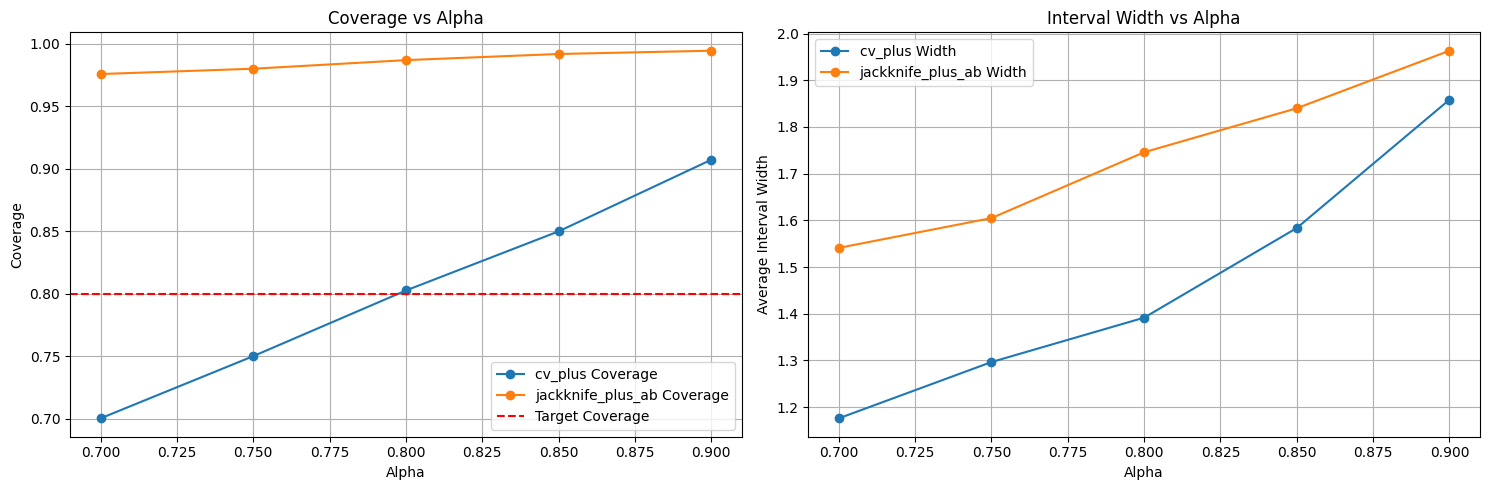

In [ ]:
# 1. First define the methods with parameters you want to test
methods = {
    "cv_plus": {"n_folds": 10},
    "jackknife_plus_ab": {"n_resamplings": 50}
}

alphas = [0.7, 0.75, 0.8, 0.85, 0.9]

# 2. Create dictionaries to store results
results = {
    method: {
        "coverage": [],
        "interval_width": [],
        "nonzero_coverage": [],
        "nonzero_width": []
    } 
    for method in methods
}

# 3. Run the experiment
for method_name in methods:
    for alpha in alphas:
        if method_name == "cv_plus":
            predictions, quantile = cv_plus_conformal(
                X=X,
                y_binary=y_pred_all,  # Your binary predictions
                y_continuous=normalized_pctg_change,
                n_folds=methods[method_name]["n_folds"],
                alpha=alpha
            )
        else:  # jackknife_plus_ab
            predictions, quantile = jackknife_plus_ab_conformal(
                X=X,
                y_binary=y_pred_all,  # Your binary predictions
                y_continuous=normalized_pctg_change,
                n_resamplings=methods[method_name]["n_resamplings"],
                alpha=alpha
            )
        
        # Create intervals
        lower_bound = predictions - quantile
        upper_bound = predictions + quantile
        
        # Calculate metrics
        coverage = np.mean((normalized_pctg_change >= lower_bound) & 
                         (normalized_pctg_change <= upper_bound))
        interval_width = np.mean(upper_bound - lower_bound)
        
        # Calculate non-zero metrics
        nonzero_mask = y_pred_all == 1
        nonzero_coverage = np.mean((normalized_pctg_change[nonzero_mask] >= lower_bound[nonzero_mask]) & 
                                 (normalized_pctg_change[nonzero_mask] <= upper_bound[nonzero_mask]))
        nonzero_width = np.mean(upper_bound[nonzero_mask] - lower_bound[nonzero_mask])
        
        # Store results
        results[method_name]["coverage"].append(coverage)
        results[method_name]["interval_width"].append(interval_width)
        results[method_name]["nonzero_coverage"].append(nonzero_coverage)
        results[method_name]["nonzero_width"].append(nonzero_width)

# 4. Print results
for method_name in methods:
    print(f"\nResults for {method_name}:")
    print("Alpha\tCoverage\tWidth\tNonzero Coverage\tNonzero Width")
    for i, alpha in enumerate(alphas):
        print(f"{alpha:.2f}\t{results[method_name]['coverage'][i]:.3f}\t"
              f"{results[method_name]['interval_width'][i]:.3f}\t"
              f"{results[method_name]['nonzero_coverage'][i]:.3f}\t"
              f"{results[method_name]['nonzero_width'][i]:.3f}")

# 5. Visualize results
plt.figure(figsize=(15, 5))

# Coverage plot
plt.subplot(1, 2, 1)
for method_name in methods:
    plt.plot(alphas, results[method_name]["coverage"], 
             marker='o', label=f"{method_name} Coverage")
plt.axhline(y=0.8, color='r', linestyle='--', label='Target Coverage')
plt.xlabel('Alpha')
plt.ylabel('Coverage')
plt.title('Coverage vs Alpha')
plt.legend()
plt.grid(True)

# Width plot
plt.subplot(1, 2, 2)
for method_name in methods:
    plt.plot(alphas, results[method_name]["interval_width"], 
             marker='o', label=f"{method_name} Width")
plt.xlabel('Alpha')
plt.ylabel('Average Interval Width')
plt.title('Interval Width vs Alpha')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()